In [9]:
import numpy as np
import pandas as pd

import seaborn
import matplotlib.pyplot as plt
seaborn.set()
%matplotlib inline

In [ ]:
# https://github.com/kiddick/speller
import requests


class Speller(object):
    service = 'http://speller.yandex.net/services/spellservice.json/checkText'

    def __init__(self, text, options=None, lang=None, format_text=None):
        self.text = text
        self.options = options
        self.lang = lang
        self.format_text = format_text
        self._answer = None

    def check(self):
        data = {'text': self.text}
        if self.options:
            data['options'] = self.options
        if self.lang:
            data['lang'] = self.lang
        if self.format_text:
            data['format'] = self.format_text
        answer = requests.post(url=self.service, data=data).json()
        return answer

    @property
    def answer(self):
        if self._answer is None:
            self._answer = self.check()
        return self._answer

    @property
    def correct(self):
        return not self.answer

    @property
    def spellsafe(self):
        raise NotImplementedError("Subclasses should implement this!")


class Word(Speller):

    @property
    def variants(self):
        if self.correct:
            return
        return self.answer[0]['s']

    @property
    def spellsafe(self):
        if self.correct:
            return
        return self.variants[0]


class Text(Speller):

    @property
    def spellsafe(self):
        changes = {el['word']: el['s'][0] for el in self.answer if len(el['s']) > 0}
        result = self.text
        for wrong, fixed in changes.items():
            result = result.replace(wrong, fixed)
        return result

    @property
    def errors(self):
        return [el['word'] for el in self.answer]

def spellcheck_dataframe_simple(dataframe, text_field='text', lang=None):
    fixed_texts = []

    total = len(dataframe)
    for idx, line in tqdm(dataframe.iterrows(), total=total, leave=False):
        fixed_text = Text(line[text_field], lang=lang).spellsafe
        fixed_texts.append(fixed_text)

    return fixed_texts

print(Text('42 is a cUl maagic namber').spellsafe)

# Rusenteval

In [7]:
ls /data/classification/rusentiment/Dataset/

rusentiment_preselected_posts.csv*  rusentiment_test.csv*
rusentiment_random_posts.csv*


In [8]:
ls /data/classification/rusentiment

Dataset/  Guidelines/  LICENSE.md  README.md


### preselected

In [21]:
filepath = '/data/classification/rusentiment/original/Dataset/rusentiment_preselected_posts.csv'
data = pd.read_csv(filepath)
data.sample(2)

,label,text,text_spellchecked
113,negative,Прощай Авгур... Пусть земля тебе будет пухом.....,Прощай Авгур... Пусть земля тебе будет пухом.....
4423,neutral,Выжрать любой ценой!,Выжрать любой ценой!


In [16]:
assert False, 'do not call me again'
spellchecked = spellcheck_dataframe_simple(data, lang='ru', text_field='text')
data['text_spellchecked'] = spellchecked
print('changed texts ratio: ', sum(data.text != data.text_spellchecked) / len(data))
data.to_csv(filepath, index=False)

changed texts ratio:  0.2529496402877698


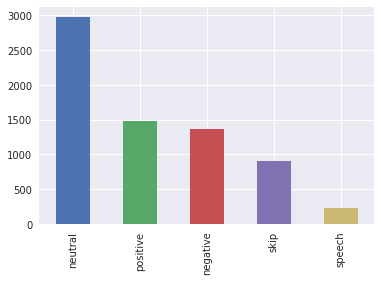

In [10]:
data.label.value_counts().plot(kind='bar')

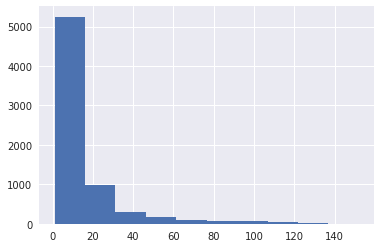

In [18]:
data.text.str.split(' ').str.len().hist()

In [23]:
len(data.drop_duplicates('text')) / len(data)

1.0

In [24]:
indices = list(data.index)
np.random.shuffle(indices)

VAL_SIZE = 0.15

val_size = int(len(indices) * VAL_SIZE)
train_size = len(indices) - val_size

train_idxs = indices[:train_size]
valid_idxs = indices[train_size:]

print('Train: ', train_size)
print('Valid: ', val_size)

Train:  5908
Valid:  1042


In [25]:
train_data = data.loc[train_idxs]
valid_data = data.loc[valid_idxs]

In [26]:
train_data.to_csv('/data/classification/rusentiment/preselected/train.csv', index=False)
valid_data.to_csv('/data/classification/rusentiment/preselected/validation.csv', index=False)

### random

In [12]:
filepath = '/data/classification/rusentiment/original/Dataset/rusentiment_random_posts.csv'
data = pd.read_csv(filepath)
data.sample(2)

,label,text,text_spellchecked
9521,speech,ВЫПУСКНИЦА ТЫ МОЯ С ПРАЗДНИКОМ ТЕБЯ ДОРОГАЯ МО...,ВЫПУСКНИЦА ТЫ МОЯ С ПРАЗДНИКОМ ТЕБЯ ДОРОГАЯ МО...
12694,positive,- the Milky Way! Ошеломляюще красиво и реали...,- the Milky Way! Ошеломляюще красиво и реали...


In [20]:
assert False, 'do not call me again'
spellchecked = spellcheck_dataframe_simple(data, lang='ru', text_field='text')
data['text_spellchecked'] = spellchecked
print('changed texts ratio: ', sum(data.text != data.text_spellchecked) / len(data))
data.to_csv(filepath, index=False)

changed texts ratio:  0.24924769606921196


In [21]:
data.label.unique()

array(['negative', 'speech', 'skip', 'neutral', 'positive'], dtype=object)

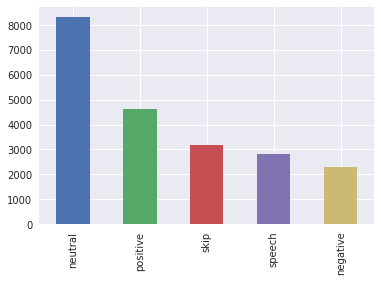

In [13]:
data.label.value_counts().plot(kind='bar')

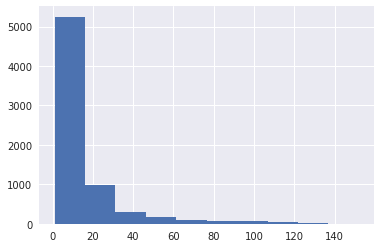

In [19]:
data.text.str.split(' ').str.len().hist()

## testset

In [15]:
filepath = '/data/classification/rusentiment/original/Dataset/rusentiment_test.csv'
data = pd.read_csv(filepath)
data.sample(2)

,label,text,text_spellchecked
2865,skip,привет)\nв смисле з ким?\nсама),привет)\nв смысле з Ким?\nсама)
639,neutral,По всей форме,По всей форме


In [26]:
assert False, 'do not call me again'
spellchecked = spellcheck_dataframe_simple(data, lang='ru', text_field='text')
data['text_spellchecked'] = spellchecked
print('changed texts ratio: ', sum(data.text != data.text_spellchecked) / len(data))
data.to_csv(filepath, index=False)

changed texts ratio:  0.254128749578699


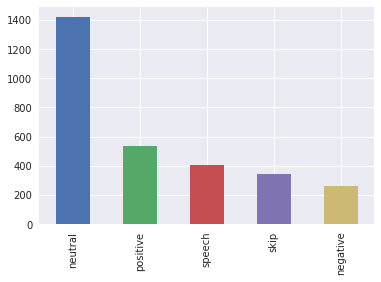

In [16]:
data.label.value_counts().plot(kind='bar')

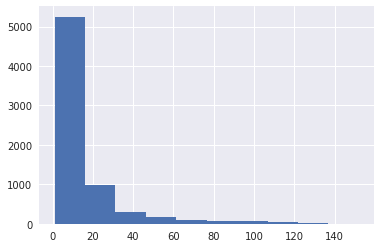

In [20]:
data.text.str.split(' ').str.len().hist()